# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: *У нас y_random содержит predict_proba, то есть вероятность принадлежности объектов к какому-то из классов, а она как раз равна 0.5)*

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000 



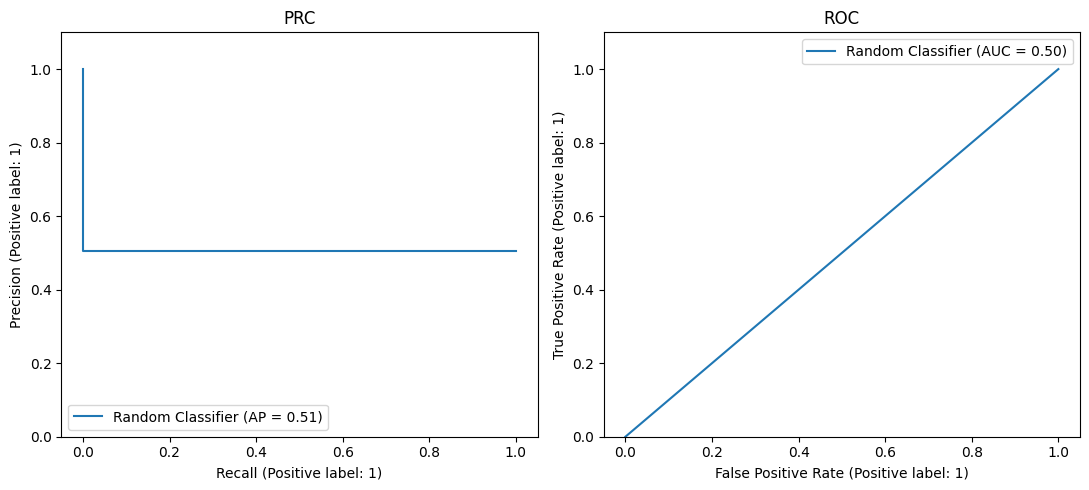

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None, draw = True, print_metrics = True):
  if draw:
    if ax is None:
      fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  auc_pr = auc(recall, precision)
  auc_roc = roc_auc_score(y_true, y_pred)

  if draw:
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)
    plt.tight_layout()
    plt.legend()
  if print_metrics:
    print(classifier_name, 'metrics')
    print('AUC-PR: %.5f' % auc(recall, precision))
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred), "\n")

  return auc_pr, auc_roc


random_auc_pr, random_auc_roc = depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
#your code here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
C_val = np.logspace(-3, 3, 5)
best_aucpr = 0
best_C_svm = None

for C in C_val:
  svm = SVC(kernel='linear').fit(X_train_svm, y_train_svm)
  y_proba = svm.decision_function(X_val_svm)
  auc_pr, _ = depict_pr_roc(
      y_val_svm,
      y_proba,
      classifier_name="SVC",
      ax=None,
      draw=False,
      print_metrics=False,
    )
  if auc_pr > best_aucpr:
    best_aucpr = auc_pr
    best_C_svm = C

In [ ]:
print("Best C is", best_C_svm)

Best C is 0.001


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVC metrics
AUC-PR: 0.82136
AUC-ROC: 0.84726 



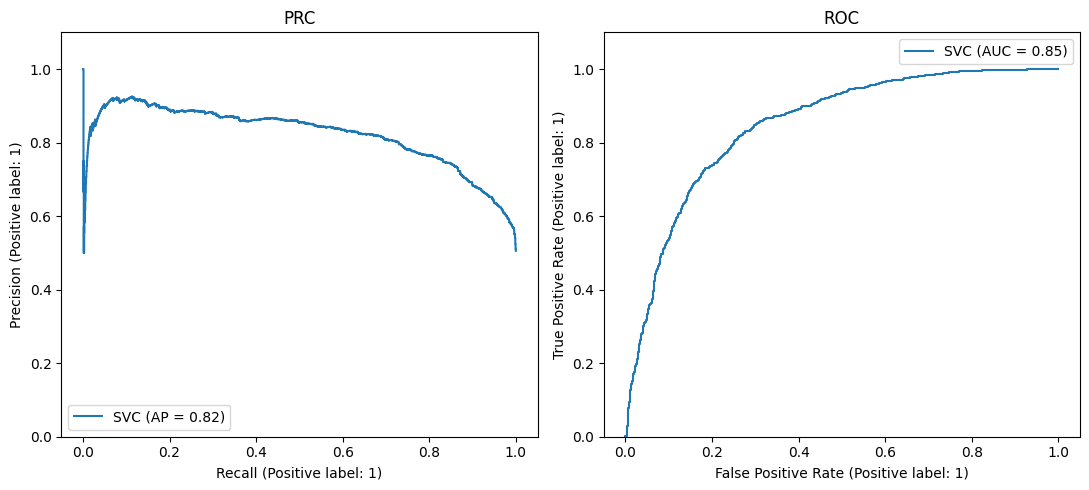

In [ ]:
#your code here
svm = SVC(kernel='linear', C = best_C_svm).fit(X_train, y_train)
y_proba = svm.decision_function(X_test)
svm_auc_pr, svm_auc_roc = depict_pr_roc(
      y_test,
      y_proba,
      classifier_name="SVC",
      ax=None,
      draw=True,
      print_metrics=True,
    )

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
#your code here
print(svm_auc_pr > random_auc_pr, 'Разница в AUC-PR: ', svm_auc_pr - random_auc_pr)
print(svm_auc_roc > random_auc_roc, 'Разница в AUC-ROC: ', svm_auc_roc - random_auc_roc)

True Разница в AUC-PR:  0.0685243470603848
True Разница в AUC-ROC:  0.34725904793993534


AUC-ROC и AUC-PR стали значительно лучше с SVM

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
#your code here
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty="l2", solver='liblinear')
param_grid = {'C': np.logspace(-3, 1, 10)}
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc')
grid_search_lr.fit(X_train,y_train)
best_C_lr = grid_search_lr.best_params_['C']

In [ ]:
print("Best C for LR is", best_C_lr)

Best C for LR is 0.05994842503189409


LR metrics
AUC-PR: 0.82907
AUC-ROC: 0.84785 



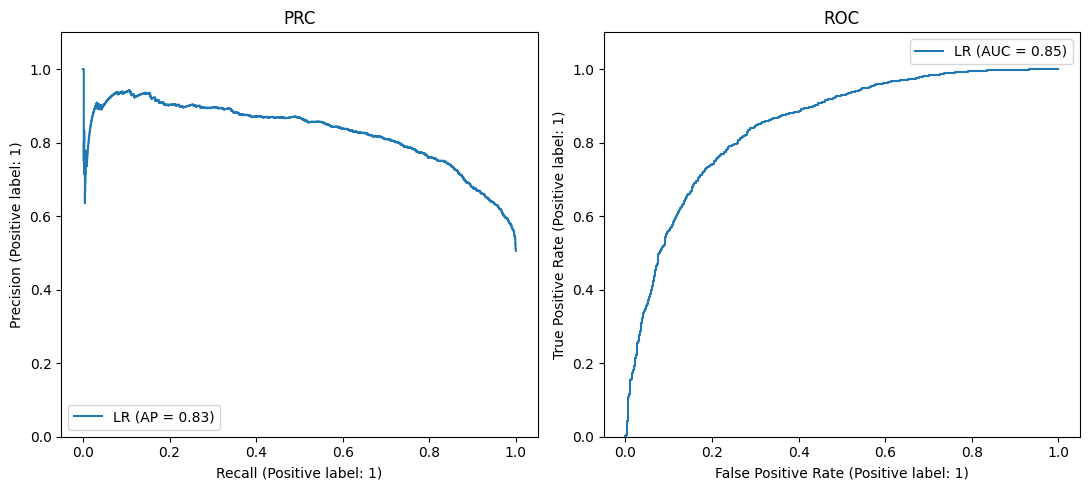

In [ ]:
#your code here
lr = LogisticRegression(penalty="l2", solver='liblinear', C = best_C_lr).fit(X_train, y_train)
y_proba = lr.decision_function(X_test)
lr_auc_pr, lr_auc_roc = depict_pr_roc(
      y_test,
      y_proba,
      classifier_name="LR",
      ax=None,
      draw=True,
      print_metrics=True,
    )

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000 

SVC metrics
AUC-PR: 0.82136
AUC-ROC: 0.84726 

LR metrics
AUC-PR: 0.82907
AUC-ROC: 0.84785 



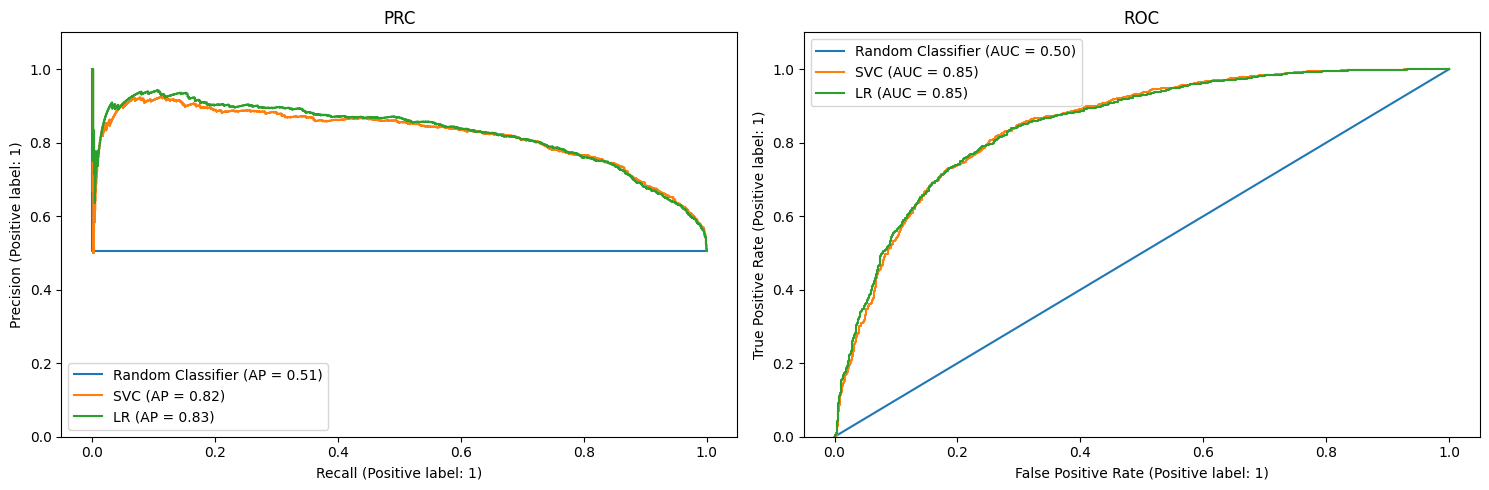

In [ ]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
depict_pr_roc(y_test, y_random, classifier_name="Random Classifier", ax=ax, draw=True, print_metrics=True)

svm = SVC(kernel='linear', C=best_C_svm).fit(X_train, y_train)
y_proba_svm = svm.decision_function(X_test)
depict_pr_roc(y_test, y_proba_svm, classifier_name="SVC", ax=ax, draw=True, print_metrics=True)

lr = LogisticRegression(penalty='l2', solver='liblinear', C=best_C_lr).fit(X_train, y_train)
y_proba_logreg = lr.predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_proba_logreg, classifier_name="LR", ax=ax, draw=True, print_metrics=True)

plt.show()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** LR и SVM получают примерно похожие значения по AUC-ROC и AUC-PR, но у LR они немного больше. Разница может быть в самой сути алгоритмов. SVM ищет лучшую разделяющую гиперплоскость, а LR напрямую считает уверенность модели в ответе.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
#your code here
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#your code here
model = SVC(kernel='linear').fit(X_train, y_train)
y_proba = model.decision_function(X_train)
support_vectors = model.support_vectors_

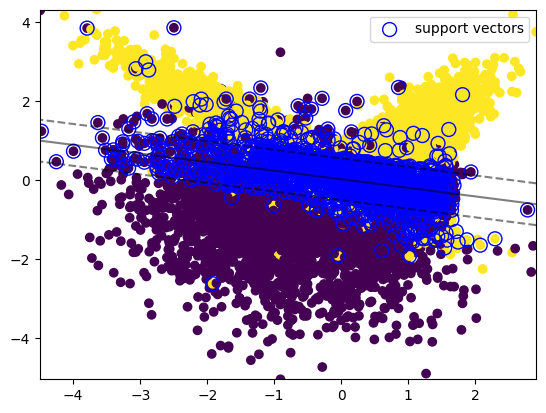

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(#your code here
                X[:, 0], X[:, 1], c=y
                )

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(#your code here
                   support_vectors[:, 0], support_vectors[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Фиолетовые точки, обведённые кружком, лежащие на гиперплоскости

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
#your code here
model = LogisticRegression(penalty="l2", solver='liblinear', C = best_C_lr).fit(X_train, y_train)

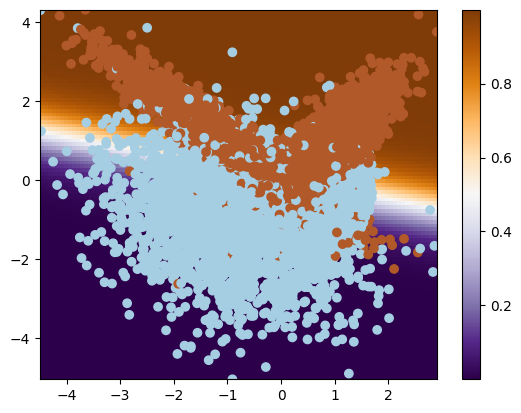

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(#your code here
                X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image);


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На картинке область, где модель не уверена, соответсвует месту, где логистическая регрессия принимает значение 0.5, вероятность переходит от одного класса к другому, белая наклонная линия. Теоретически эта область соответствует месту, где скалярное произведение x на w равна 0 и по этой линии происходит переход от одного класса к другому.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(ax, y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #!
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #!
    ax.plot(bin_middle_points, bin_real_ratios, label=name)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
svm = SVC(kernel='linear', C = best_C_svm).fit(X_train, y_train)
lr = LogisticRegression(penalty="l2", solver='liblinear', C = best_C_lr).fit(X_train, y_train)

In [ ]:
svm_probs = svm.decision_function(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]
svm_probs = (svm_probs - svm_probs.min()) / (svm_probs.max() - svm_probs.min())

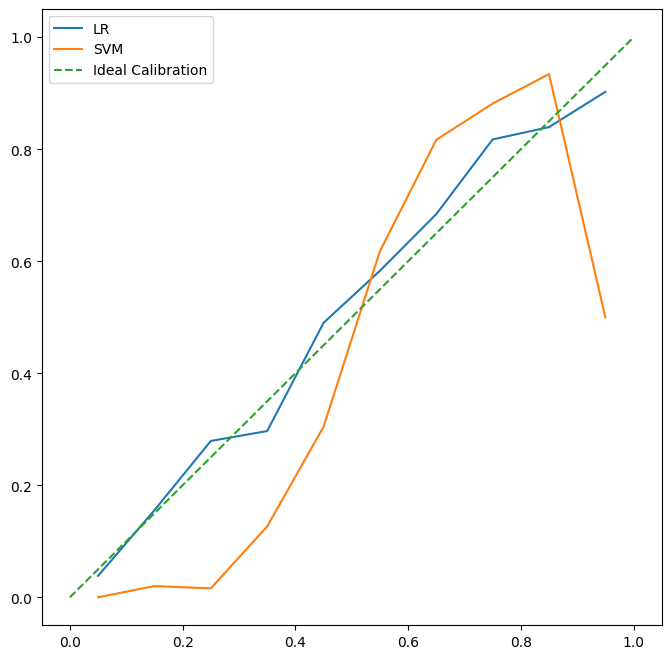

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_calibration_curve(ax, y_test, lr_probs, name='LR')
plot_calibration_curve(ax, y_test, svm_probs, name='SVM')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal Calibration')
ax.legend();

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** LR откалибрована нормально, но всё же достаточно заметны различия с идеально откалиброванной моделью, а вот SVM откалибрована плохо, находится далеко от диагонали.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

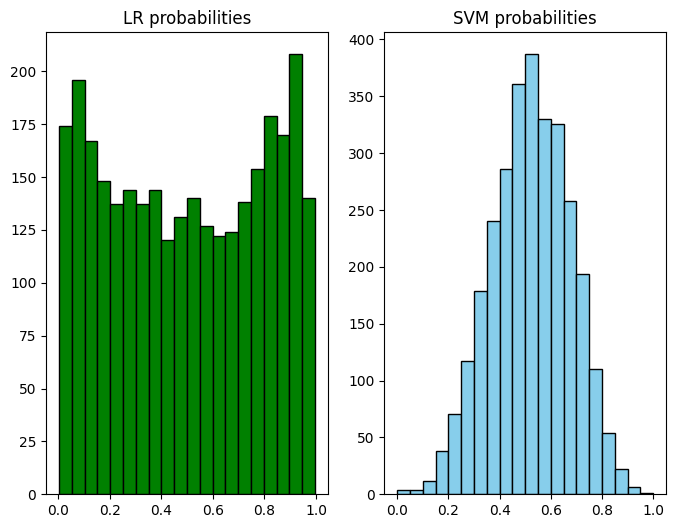

In [ ]:
#your code here
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.hist(lr_probs, bins=20, color = 'green', edgecolor='black')
plt.title("LR probabilities")
plt.subplot(1, 2, 2)
plt.hist(svm_probs, bins=20, color = 'skyblue', edgecolor='black')
plt.title("SVM probabilities");

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У LR гистограмма сначала убывает потом возрастает, у SVM похожа на нормальное распределение. Форма гистограммы LR может быть связана с тем, как часто модель выдает уверенные предсказания (вероятности близкие к 0 или 1), а SVM скорее не уверен в своих ответах (даёт в основном результат 0.5).

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [ ]:
#your code here
from sklearn.calibration import CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(svm)
calibrated_svm.fit(X_train, y_train)

CalibratedClassifierCV(estimator=SVC(C=0.001, kernel='linear'))

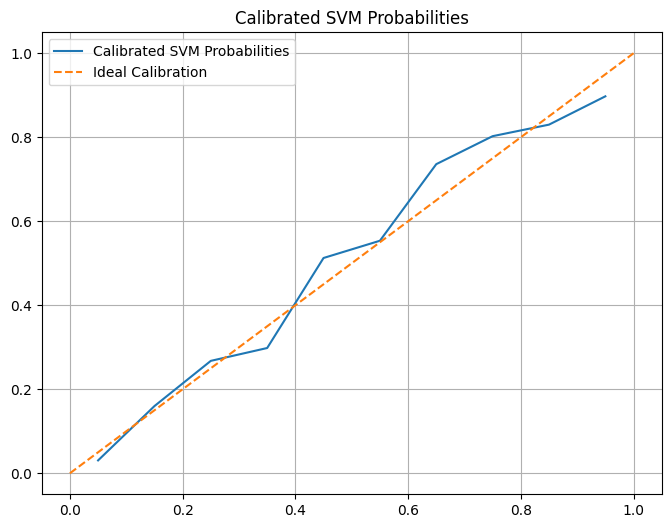

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
calibrated_svm_probs = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve(ax, y_test, calibrated_svm_probs, name='Calibrated SVM Probabilities')
plt.title('Calibrated SVM Probabilities')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal Calibration')
ax.legend();

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Кривая улучшилась, значительно ближе стала к диагонали

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [ ]:
#Заменим пропуски категориальных переменных
df[df.select_dtypes(include='object').columns] = df[df.select_dtypes(include='object').columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[['ID', 'Income', 'Children', 'Cars', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
#your code here
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.metrics import average_precision_score

ord_enc = OrdinalEncoder()

start = time.time()
X_train_encoded = ord_enc.fit_transform(X_train)
X_test_encoded = ord_enc.transform(X_test)
lr = LogisticRegression(penalty="l2", solver='liblinear', max_iter = 10000)
lr.fit(X_train_encoded, y_train)
end = time.time()

y_pred = lr.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)
time_ord = end-start

print("AUC_PR: ", auc_pr)
print("Time: ", time_ord)

AUC_PR:  0.5904527492826406
Time:  0.048104047775268555


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
#your code here
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder().fit(X_train, y_train)

start = time.time()
X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)
lr = LogisticRegression(penalty="l2", solver='liblinear', max_iter = 10000)
lr.fit(X_train_ohe, y_train)
end = time.time()

y_pred_ohe = lr.predict_proba(X_test_ohe)[:, 1]
auc_pr_ohe = average_precision_score(y_test, y_pred_ohe)
time_ohe = end - start

print("AUC-PR for OHE: ", auc_pr_ohe)
print("Time for OHE: ", time_ohe)

AUC-PR for OHE:  0.6659403577096267
Time for OHE:  0.010624408721923828


In [ ]:
print("Number of features before OHE: ", X_train.shape[1], "\nNumber of features after OHE: ", X_train_ohe.shape[1])

Number of features before OHE:  7 
Number of features after OHE:  27


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
#your code here
X_train_mte = X_train.copy()
X_test_mte = X_test.copy()
df_cat_train = X_train.copy()
df_cat_train['Target'] = y_train.copy()

start = time.time()
for feature in X_train.columns:
  feature_mean = df_cat_train.groupby(feature)['Target'].mean()
  X_train_mte[feature] = X_train[feature].map(feature_mean)
  X_test_mte[feature] = X_test[feature].map(feature_mean)

lr = LogisticRegression(penalty="l2", solver='liblinear', max_iter = 10000)
lr.fit(X_train_mte, y_train)
end = time.time()

y_pred_mte = lr.predict_proba(X_test_mte)[:, 1]
auc_pr_mte = average_precision_score(y_test, y_pred_mte)
time_mte = end - start

print("AUC-PR for MTE: ", auc_pr_mte)
print("Time for MTE: ", time_mte)

AUC-PR for MTE:  0.6476977889272284
Time for MTE:  0.022397518157958984


In [ ]:
print("Time for OE: ", time_ord)
print("Time for OHE: ", time_ohe)
print("Time for MTE: ", time_mte)

Time for OE:  0.014266252517700195
Time for OHE:  0.010624408721923828
Time for MTE:  0.022397518157958984


MTE у меня получился хуже по времени и вместе с этим AUC-PR у него хуже OHE и лучше OE

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin
class SanchEstimator(BaseEstimator, TransformerMixin):
  def __init__(self, features_columns):
    self.features_columns = features_columns
    self.feature_mean = {}

  def fit(self, X, y):
    df_cat = X.copy()
    df_cat['Target'] = y.copy()
    for feature in self.features_columns:
      feature_mean = df_cat.groupby(feature)['Target'].mean()
      self.feature_mean[feature] = feature_mean

    return self


  def transform(self, X):
    X_est = X.copy()
    for feature in X.columns:
      X_est[feature] = X[feature].map(self.feature_mean[feature])

    return X

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
#your code here
class NoisySanchEstimator(BaseEstimator, TransformerMixin):
  def __init__(self, features_columns, noise):
    self.features_columns = features_columns
    self.feature_mean = {}
    self.noise = noise

  def fit(self, X, y):
    df_cat = X.copy()
    df_cat['Target'] = y.copy()
    for feature in self.features_columns:
      feature_mean = df_cat.groupby(feature)['Target'].mean()
      self.feature_mean[feature] = feature_mean

    return self


  def transform(self, X):
    X_est = X.copy()
    for feature in X.columns:
      X_est[feature] = X[feature].map(self.feature_mean[feature])
      np.random.seed(3)
      X_est[feature] += np.random.normal(0.01, self.noise, X_est.shape[0])

    return X_est

In [ ]:
est = NoisySanchEstimator(X_train.columns, 0.1)

In [ ]:
X_train_noise = X_train.copy()
X_test_noise = X_test.copy()

start = time.time()
est.fit(X_train, y_train)
X_train_noise = est.transform(X_train)
X_test_noise = est.transform(X_test)
lr = LogisticRegression(penalty="l2", solver='liblinear')
lr.fit(X_train_noise, y_train)
end = time.time()

y_pred_noise = lr.predict_proba(X_test_noise)[:, 1]
auc_pr_noise = average_precision_score(y_test, y_pred_noise)
time_noise = end - start

print("AUC-PR for noise: ", auc_pr_noise)
print("Time for noise: ", time_noise)

AUC-PR for noise:  0.6120773078545192
Time for noise:  0.032790184020996094


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Не особо, время и AUC-PR стали хуже))) Может быть слишком высокий шум

 ¯\_(ツ)_/¯

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
#your code here
class SmoothNoisySanchEstimator(BaseEstimator, TransformerMixin):
  def __init__(self, features_columns, noise):
    self.features_columns = features_columns
    self.feature_mean = {}
    self.noise = noise
    self.global_mean = None

  def fit(self, X, y, C):
    df_cat = X.copy()
    df_cat['Target'] = y.copy()
    self.global_mean = np.mean(y)
    for feature in self.features_columns:
      feature_mean = df_cat.groupby(feature)['Target'].agg(['sum', 'count'])
      smoothing = (feature_mean['sum'] + C * self.global_mean) / (feature_mean['sum'] + C)
      self.feature_mean[feature] = smoothing

    return self


  def transform(self, X):
    X_est = X.copy()
    for feature in X.columns:
      X_est[feature] = X[feature].map(self.feature_mean[feature]).fillna(self.global_mean)
      np.random.seed(3)
      X_est[feature] += np.random.normal(0.01, self.noise, X_est.shape[0])

    return X_est

In [ ]:
est = SmoothNoisySanchEstimator(X_train.columns, 0.1)
X_train_smooth = X_train.copy()
X_test_smooth = X_test.copy()

C_vals = np.logspace(-7, 1, 100)

for c in C_vals:
  start = time.time()
  est.fit(X_train_smooth, y_train, c)
  X_train_smooth = est.transform(X_train)
  X_test_smooth = est.transform(X_test)
  lr = LogisticRegression(penalty="l2", solver='liblinear')
  lr.fit(X_train_smooth, y_train)
  y_pred_smooth = lr.predict_proba(X_test_smooth)[:, 1]
  auc_pr_smooth = average_precision_score(y_test, y_pred_smooth)
  end = time.time()
  time_smooth = end - start
  if auc_pr_smooth > auc_pr_ohe:
    print("AUC-PR for smooth estimator: ", auc_pr_smooth)
    print("Time for smooth estimator: ", time_smooth)
    break

In [ ]:
print("AUC-PR for smooth estimator: ", auc_pr_smooth)
print("Time for smooth estimator: ", time_smooth)

AUC-PR for smooth estimator:  0.4696097391604146
Time for smooth estimator:  0.03406858444213867


У меня не получилось подобрать C, чтобы лучше OHE было, но зато работает!)))

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
#your code here
df['Income'] = df["Income"].fillna(df['Income'].mean())
df['Age'] = df["Age"].fillna(df['Age'].mean())
df['Cars'] = df["Cars"].fillna(df['Cars'].mean())
df['Children'] = df["Children"].fillna(df['Children'].mean())
df['ID'] = df["Income"].fillna(df['Income'].mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
#your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
est = SmoothNoisySanchEstimator(X_train.columns, 0.1)

start = time.time()
est.fit(X_train, y_train, 10)
X_train = est.transform(X_train)
X_test = est.transform(X_test)
lr = LogisticRegression(penalty="l2", solver='liblinear')
lr.fit(X_train, y_train)
y_pred_all = lr.predict_proba(X_test)[:, 1]
auc_pr_all = average_precision_score(y_test, y_pred_all)
end = time.time()

time_all = end - start
print("AUC-PR for smooth estimator: ", auc_pr_all)
print("Time for smooth estimator: ", time_all)

AUC-PR for smooth estimator:  0.5593460249359032
Time for smooth estimator:  0.06618452072143555


Стало лучше, чем в предыдущий раз, и AUC-PR, и время улучшились

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Счётчики можно настроить для борьбы с редкими категориям, так как можно применить сглаживание. Также они занимают меньше памяти, чем OHE. Однако счётчики в свою очередь могут привести к переобучению.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-23 01:00:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.52MB/s    in 0.5s    

2023-11-23 01:01:00 (7.52 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7959,49,Private,165152,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,48,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
#your code here
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
#your code here
df_encoded = pd.get_dummies(df)

In [ ]:
print(df_encoded.shape[1] - df.shape[1], 'новых признаков')

94 новых признаков


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
#your code here
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
print(auc_pr)

0.4503318285414827


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
#your code here
from sklearn.feature_selection import SelectKBest, f_classif #с помощью skb выбираем лучшие, которые определены с помощью f_classif (гпт подсказал)
skb = SelectKBest(f_classif, k = 40)
skb.fit(X_train, y_train)

X_train_40 = skb.transform(X_train)
X_test_40 = skb.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_40, y_train)
y_pred_40 = lr.predict_proba(X_test_40)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_40)
auc_pr_40 = auc(recall, precision)
print(auc_pr_40)

0.7202958534734748


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?

AUC-PR стал гораздо лучше, на 30%. Наверное, потому что мы выкинули ненужные признаки.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
#your code here
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

skb = SelectKBest(f_classif, k = 40)
skb.fit(X_train_scaled, y_train)

X_train_scaled_40 = skb.transform(X_train_scaled)
X_test_scaled_40 = skb.transform(X_test_scaled)

lr = LogisticRegression()
lr.fit(X_train_scaled_40, y_train)
y_pred_scale = lr.predict_proba(X_test_scaled_40)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_scale)
auc_pr_scale = auc(recall, precision)
print(auc_pr_scale)

0.7619860369914577


*Качество опять стало лучше!*

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
df.select_dtypes(include='object').columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [ ]:
#your code here
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

skb = SelectKBest(f_classif, k=40)
prep = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']),
        ('cat', OneHotEncoder(), ['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country'])
    ]
)
pipeline = Pipeline([
    ('preprocessor', prep),
    ('selector', skb),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict_proba(X_test)[:, 1]
auc_pr_pipeline = average_precision_score(y_test, y_pred_pipeline)
print(auc_pr_pipeline)

0.7621197324599572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Качество стало немного лучше

Два пункта ниже я не делал, перешёл к экономическим

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-23 01:01:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.38MB/s    in 0.3s    

2023-11-23 01:01:03 (1.38 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here
numerical_columns = X.select_dtypes(exclude='object').columns
categorical_columns = X.select_dtypes(include='object').columns
prep = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])
lr = LogisticRegression()

pipeline = Pipeline(steps = [('preprocessor', prep), ('classifier', lr)])
cnt = 0
answers = {}

for train_ind, test_ind in kf.split(df):
  X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
  y_train, y_test = df['y'].iloc[train_ind], df['y'].iloc[test_ind]

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  answers[cnt] = y_pred
  cnt += 1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here
revs = np.array([])
costs = np.array([])
for k, val in answers.items():
  rev = len(answers[k][val == 'yes']) * 10
  cost = len(answers[k])
  revs = np.append(revs, rev)
  costs = np.append(costs, cost)

In [ ]:
print("Средняя выручкая", np.mean(revs))
print("Средние издержки", np.mean(costs))
print("Стандартное отклонение", np.std(revs))

Средняя выручкая 3234.0
Средние издержки 8237.6
Стандартное отклонение 78.63841300535


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here
revs_random = np.array([])
costs_random = np.array([])
for k, val in answers.items():
  rev_random = len(answers[k][val == 'yes']) * np.random.uniform(0, 20)
  cost_random = len(answers[k])
  revs_random = np.append(revs_random, rev_random)
  costs_random = np.append(costs_random, cost_random)

In [ ]:
print("Средняя выручкая", np.mean(revs_random))
print("Средние издержки", np.mean(costs_random))
print("Стандартное отклонение", np.std(revs_random))

Средняя выручкая 3339.856460277875
Средние издержки 8237.6
Стандартное отклонение 1967.280953423098


Выручка стала меньше вроде

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here
best_revenue = 0
best_C = None
total_revenues = []
stds = []

C_values = np.logspace(-3, 3, 7)

for C in C_values:
  revs = np.array([])
  for train_ind, test_ind in kf.split(df):
    lr = LogisticRegression(C=C)
    pipeline = Pipeline(steps = [('preprocessor', prep), ('classifier', lr)])

    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = df['y'].iloc[train_ind], df['y'].iloc[test_ind]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    revenue = sum((y_pred == 'yes') * np.random.uniform(0, 20))
    revs = np.append(revs, revenue)
  stds.append(np.std(revs))
  total_revenues.append(np.mean(revs))

  if np.mean(revs) > best_revenue:
    best_revenue = np.mean(revs)
    best_C = C

print("Best C is", best_C)
print("Best revenue is", best_revenue)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best C is 1000.0
Best revenue is 4279.217567267982


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Best C is", best_C)
print("Best revenue is", best_revenue)

Best C is 1000.0
Best revenue is 4279.217567267982


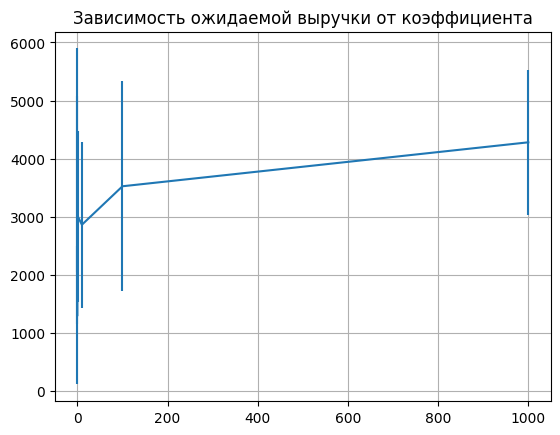

In [ ]:
plt.errorbar(C_values, total_revenues, yerr=stds)
plt.title("Зависимость ожидаемой выручки от коэффициента")
plt.grid();

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here
#your code here
best_Cs = []
best_revenues = []
for i in range(5):
  best_revenue = 0
  best_C = None
  total_revenues = []
  stds = []

  C_values = np.logspace(-3, 3, 7)

  for C in C_values:
    revs = np.array([])
    for train_ind, test_ind in kf.split(df):
      lr = LogisticRegression(C=C)
      pipeline = Pipeline(steps = [('preprocessor', prep), ('classifier', lr)])

      X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
      y_train, y_test = df['y'].iloc[train_ind], df['y'].iloc[test_ind]

      pipeline.fit(X_train, y_train)
      y_pred = pipeline.predict(X_test)

      revenue = sum((y_pred == 'yes') * np.random.uniform(0, 20))
      revs = np.append(revs, revenue)
      stds.append(np.std(revs))
      total_revenues.append(np.mean(revs))

    if np.mean(revs) > best_revenue:
      best_revenue = np.mean(revs)
      best_C = C
  best_Cs.append(best_C)
  best_revenues.append(best_revenue)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
print(best_Cs)
print(best_revenues)

[100.0, 1000.0, 1000.0, 0.1, 100.0]
[3774.5055887516414, 4674.8328011836265, 3709.196167727093, 4261.6019403453865, 3864.823363233683]


*C несколько раз совпадал, потом изменялся. Закономерность есть, он возрастает в 10 раз в момент первого изменения и в 10 раз в момент второго изменения. А вот с выручкой другое дело, там закономерность сложно найти*

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Тут важнее precision, чтобы снизить издержки на ненужные звонки и тем самым максимизировать прибыль.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here
best_revenue = 0
best_thres = None
total_revenues = []
stds = []
best_thres_arr = []

thresholds = np.arange(0, 0.8, 0.01)

for train_ind, test_ind in kf.split(df):
  lr = LogisticRegression(C=C)
  pipeline = Pipeline(steps = [('preprocessor', prep), ('classifier', lr)])

  X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
  y_train, y_test = df['y'].iloc[train_ind], df['y'].iloc[test_ind]

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict_proba(X_test)

  for threshold in thresholds:
    revs = np.array([])
    preds = (y_pred >= threshold).astype(int)
    revenue = sum((preds == 1) * np.random.uniform(0, 20))
    revs = np.append(revs, revenue)

    if np.mean(revs) > best_revenue:
      best_revenue = np.mean(revs)
      best_thres = threshold
  stds.append(np.std(revs))
  total_revenues.append(np.mean(revs))
  best_thres_arr.append(best_thres)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




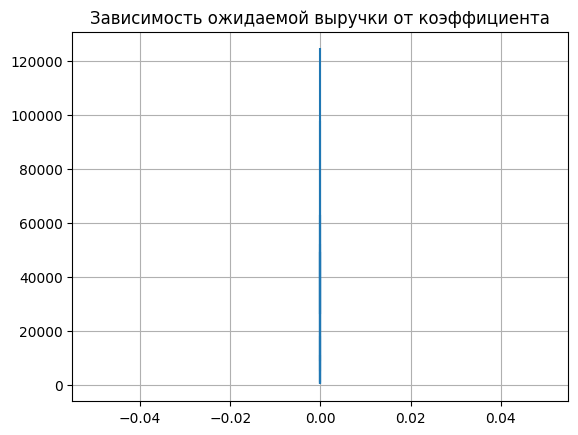

In [ ]:
#your code here
plt.errorbar(best_thres_arr, total_revenues, yerr=stds)
plt.title("Зависимость ожидаемой выручки от коэффициента")
plt.grid();

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Наверное вероятности ответов сосредоточены в определённом диапазоне и там получается максимальная прибыль